# General idea of Crack_Segmentation_clean version:
1. Pre-processs the input image: re-size -> segment -> denoise
2. Extract key points and then form tsp path based on these points
3. Identify the path thickness for each path segments
4. Visualize the theoretical output of the spraying result
5. Potential Next Steps:
  - Add speed considerations, fast for wide gap jumps, and potential buffer zone as well
  - Counter-movement to keep the sprayer on the crack path on the moving platform
  - Change the tsp path into something else and compare their performance?
  - Define start and end zone for smooth transition into the next portion of the crack

In [2]:
# @title Connect to the Google Drive
from google.colab import drive
drive.mount('/content/drive')
# TEST

Mounted at /content/drive


In [3]:
# @title Load necessary packages
import os
from PIL import Image
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import cv2
from matplotlib.collections import LineCollection
from scipy.spatial import distance_matrix
from sklearn.cluster import KMeans
import networkx as nx
from networkx.algorithms.approximation import traveling_salesman_problem
from sklearn.decomposition import PCA
from skimage import io, filters, morphology


In [4]:
# @title Resize (squeeze/stretches) the raw image into the required model input image ratio (480,320) and save to the resized folder
import os
from PIL import Image

def resize_all_raw_images(input_path, output_path, new_dimension=(480, 320)):
    # Check if the output directory exists, if not create it
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    # Counter for resized and saved files
    count = 0

    # Iterate through all files in the input directory
    for filename in os.listdir(input_path):
        # Check if the file is an image
        if filename.endswith(".jpg") or filename.endswith(".png"):
            # Open the image
            image = Image.open(os.path.join(input_path, filename))

            # Resize the image
            resized_image = image.resize(new_dimension)

            # Generate a new filename
            new_filename = os.path.splitext(filename)[0] + "_resized.jpg"

            # Save the resized image to the output directory
            resized_image.save(os.path.join(output_path, new_filename))

            # Increment the count
            count += 1

    return count

# Example usage
# -> resize_all_raw_images: accepts png,jpg only
# input_path : folder name (not file name)
# output_path : folder name (not file name) -> *_resized.jpg

# XIANG ADD CORRETION FUNCTION HERE

input_path = "/content/drive/MyDrive/Road_surface_crack_detection/finalize/raw_images"
output_path = "/content/drive/MyDrive/Road_surface_crack_detection/finalize/resized_images"
resized_count = resize_all_raw_images(input_path, output_path)
print(f"Resized and saved {resized_count} images to {output_path}.")


Resized and saved 4 images to /content/drive/MyDrive/Road_surface_crack_detection/finalize/resized_images.


In [5]:
# @title Git Clone the crack-segmentation Model https://github.com/RyM-CIC/Crack-segmentation.git
# https://github.com/RyM-CIC/Crack-segmentation.git
!git clone https://github.com/RyM-CIC/Crack-segmentation.git
%ls
%cd Crack-segmentation/
%ls

Cloning into 'Crack-segmentation'...
remote: Enumerating objects: 27, done.
remote: Total 27 (delta 0), reused 0 (delta 0), pack-reused 27
Receiving objects: 100% (27/27), 21.73 MiB | 23.37 MiB/s, done.
Resolving deltas: 100% (9/9), done.
Crack-segmentation/  drive/  sample_data/
/content/Crack-segmentation
 bestmodel_grieta_unetb.h5   README.md  'U-Net Models.ipynb'  'VGG16 Modified.ipynb'


In [6]:
# @title load the Github model with the custom F1 key - still following original Github code
from keras.models import load_model
def f1(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    tp = K.sum(y_true_f * y_pred_f)
    fp = K.sum(K.clip(K.clip(y_pred_f + y_true_f, 0, 1) - y_true_f, 0, 1))
    fn = K.sum(K.clip(K.clip(y_pred_f + y_true_f, 0, 1) - y_pred_f, 0, 1))
    Pr = tp / (tp + fp)
    Re = tp / (tp + fn)
    f1t = 2 * (Pr * Re) / (Pr + Re)
    return f1t

# Load the model
model = load_model('/content/Crack-segmentation/bestmodel_grieta_unetb.h5', custom_objects={'f1': f1})

1/1 [==============================] - 3s 3s/step


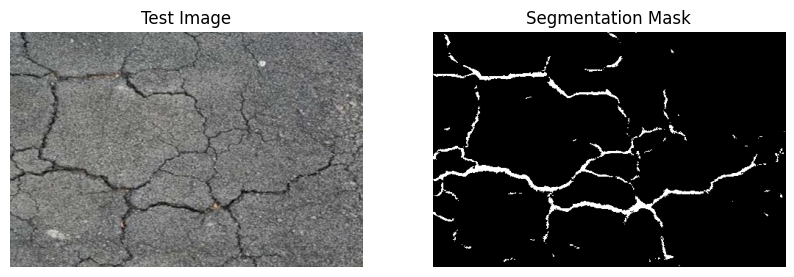

1/1 [==============================] - 2s 2s/step


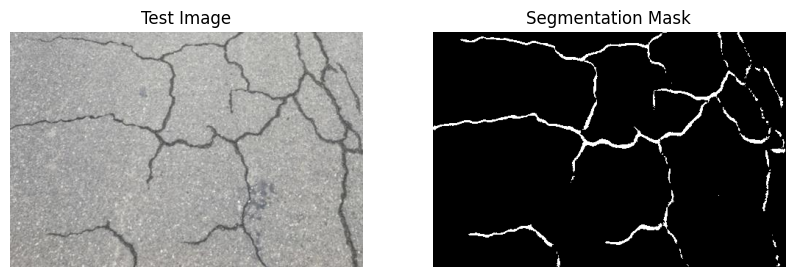

1/1 [==============================] - 4s 4s/step


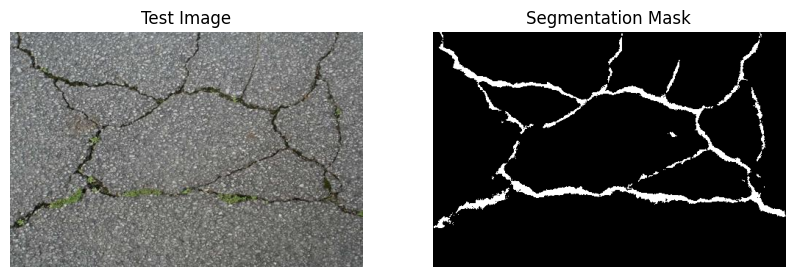

1/1 [==============================] - 2s 2s/step


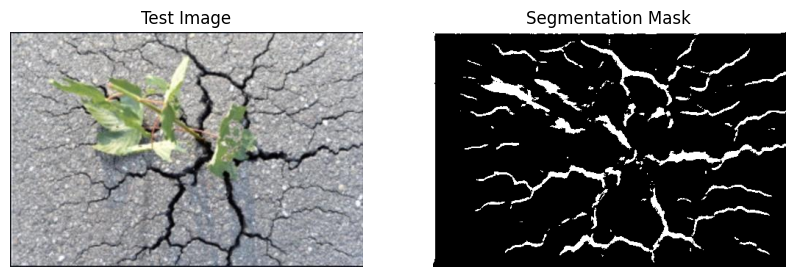

Segmented and saved 4 images to /content/drive/MyDrive/Road_surface_crack_detection/finalize/segmented_images.


In [7]:
# @title Main ML detection: Image Segmentation on a all images and save the output to output_dir
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

def segment_images(model, input_path, output_dir, threshold=0.5):
    # Check if the output directory exists, if not create it
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Counter for processed images
    count = 0

    # List to hold errors
    errors = []

    # Iterate through all files in the input directory
    for filename in os.listdir(input_path):
        # Check if the file is a JPEG image
        if filename.endswith(".jpg"):
            try:
                # Load the image
                image = Image.open(os.path.join(input_path, filename))

                # Perform segmentation using ML model
                # Represent confidence
                segmentation_mask = model.predict(np.expand_dims(image, axis=0))

                # Post-process the segmentation mask as an bw color
                binary_mask = segmentation_mask > threshold
                binary_mask_image = Image.fromarray((binary_mask[0, :, :, 0] * 255).astype(np.uint8))

                # Save the segmented image with a new filename
                output_filename = f"{os.path.splitext(filename)[0]}_segmented.jpg"
                output_path = os.path.join(output_dir, output_filename)
                binary_mask_image.save(output_path)

                # Visualize the segmentation result (optional)
                plt.figure(figsize=(10, 5))
                plt.subplot(1, 2, 1)
                plt.imshow(image)
                plt.title('Test Image')
                plt.axis('off')

                plt.subplot(1, 2, 2)
                plt.imshow(binary_mask[0, :, :, 0], cmap='gray')
                plt.title('Segmentation Mask')
                plt.axis('off')

                plt.show()

                # Increment the count
                count += 1

            except Exception as e:
                # If an error occurs, append it to the errors list
                errors.append(f"Error processing {filename}: {str(e)}")

    # If there are errors, print them
    if errors:
        for error in errors:
            print(error)

    return count

# Example Use
# input_path : folder (not file) -> only *jpg (after resize)
# output_path : folder (not file) -> *_segmented.jpg
# threshold : probablity

threshold = 0.5
model = load_model('/content/Crack-segmentation/bestmodel_grieta_unetb.h5', custom_objects={'f1': f1})
input_path = '/content/drive/MyDrive/Road_surface_crack_detection/finalize/resized_images'
output_dir = '/content/drive/MyDrive/Road_surface_crack_detection/finalize/segmented_images'

processed_count = segment_images(model, input_path, output_dir, threshold)
print(f"Segmented and saved {processed_count} images to {output_dir}.")


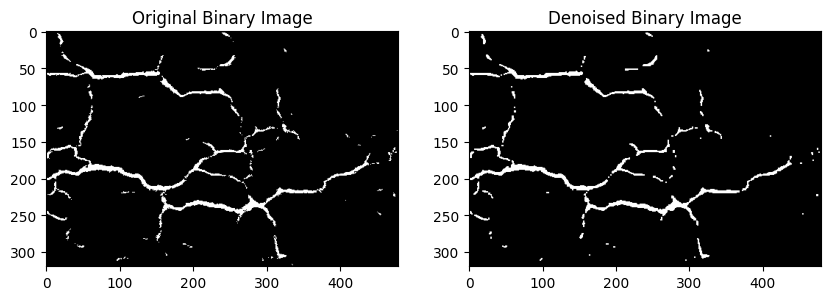

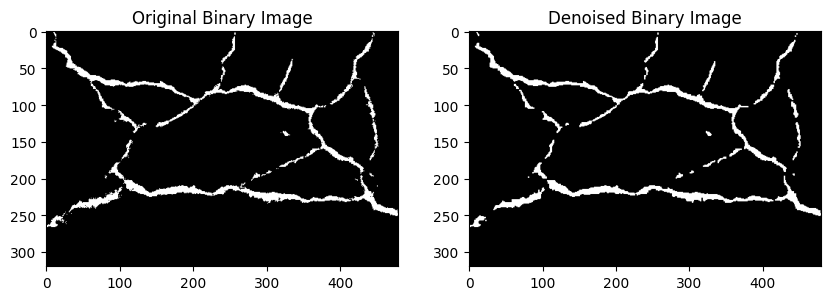

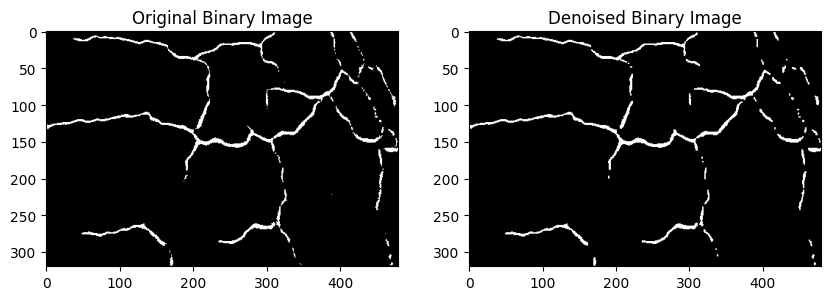

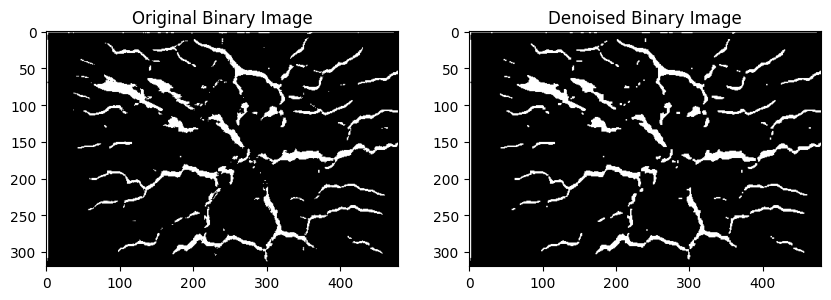

In [8]:
# @title De-noise the segmentation result to make the path less-likely to be influenced by noise dots
import matplotlib.pyplot as plt
from skimage import io, filters, morphology
import numpy as np
import os

def denoise_images(input_path, output_path, selem_radius=2):
    # Check if the output directory exists, if not create it
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    # Iterate through all files in the input directory
    for filename in os.listdir(input_path):
        # Check if the file is a JPEG image
        if filename.endswith(".jpg"):
            try:
                # Load the image
                image = io.imread(os.path.join(input_path, filename), as_gray=True)

                # Threshold the image to get a binary image
                binary = image > filters.threshold_otsu(image)

                # Define a structuring element for morphology operations
                selem = morphology.disk(radius=selem_radius)

                # Perform morphological opening to remove small white dots (noise)
                denoised_binary = morphology.opening(binary, selem)

                # Perform morphological closing to fill gaps in the main lines
                denoised_binary = morphology.closing(denoised_binary, selem)

                # Save the denoised image
                output_filename = f"denoised_{filename}"
                output_filepath = os.path.join(output_path, output_filename)
                io.imsave(output_filepath, denoised_binary.astype(np.uint8) * 255)

                # Plot the original and denoised images for comparison
                fig, axes = plt.subplots(1, 2, figsize=(10, 5))
                axes[0].imshow(binary, cmap='gray')
                axes[0].set_title('Original Binary Image')
                axes[1].imshow(denoised_binary, cmap='gray')
                axes[1].set_title('Denoised Binary Image')
                plt.show()

            except Exception as e:
                print(f"Error processing {filename}: {str(e)}")



# Example usage
# TASK -> find ground representation of "selem_radius" : define function inch2SelemRadius()
selem_radius = 1.4

input_path = '/content/drive/MyDrive/Road_surface_crack_detection/finalize/segmented_images'
output_path = '/content/drive/MyDrive/Road_surface_crack_detection/finalize/denoised_images'

denoise_images(input_path, output_path, selem_radius)

In [9]:
# @title inner_functions  used for the sprayer_path()

# optimize_crack_path() uses tsp on the original contours for higher accuracy and better coverage
'''
Change the num_cluster to fine-tune how detailed the path is going to be, the higher
the num_cluster, the more points on the
'''
# stand alone function
def optimize_crack_path(input_path, output_path, num_cluster=200):
    image = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
    _, binary_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

    # edge detection
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # keypoint creation
    key_points = []
    for contour in contours:
        for point in contour:
            key_points.append(point[0])

    key_points = np.array(key_points)
    if len(key_points) < 2:
        print("Not enough points to construct a path.")
        return None, None, None
    else:
        # creating point for path TSP problem
        key_points = key_points.reshape(-1, 2)
        num_clusters = min(len(key_points), num_cluster)
        kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_init='auto').fit(key_points)
        cluster_centers = kmeans.cluster_centers_
        labels = kmeans.labels_
        cluster_dict = {tuple(center): [] for center in cluster_centers}
        for point, label in zip(key_points, labels):
            cluster_dict[tuple(cluster_centers[label])].append(tuple(point))
        G = nx.complete_graph(len(cluster_centers))
        dist_matrix = distance_matrix(cluster_centers, cluster_centers)
        for i in range(len(cluster_centers)):
            for j in range(i + 1, len(cluster_centers)):
                G.add_edge(i, j, weight=dist_matrix[i, j])
        tsp_path = traveling_salesman_problem(G, weight='weight')

        # export centers
        tsp_coordinates = cluster_centers[tsp_path]
        return tsp_coordinates, contours, cluster_dict

# calculate_direction() uses PCA to get the direction of a cluster of points
def calculate_direction(points):
    if len(points) < 2:
        return np.array([1, 0])
    points = np.array(points)
    pca = PCA(n_components=2)
    pca.fit(points)
    direction = pca.components_[0]
    return direction

# calculate_perpendicular_direction() gets the perpendicular direction to the principle direction from the above function output
def calculate_perpendicular_direction(direction):
    perpendicular_direction = np.array([-direction[1], direction[0]])
    return perpendicular_direction

# calculate_thickness() uses point projections onto the perpendicular direction for path thickness calculation
def calculate_thickness(key_point, direction, original_points):
    perpendicular_direction = calculate_perpendicular_direction(direction)
    projections = []
    problematic_point = None
    for point in original_points:
        vector = np.array(point) - np.array(key_point)
        projection_length = np.dot(vector, perpendicular_direction)
        projections.append(projection_length)
        if len(projections) >= 2 and max(projections) - min(projections) > 20:
            problematic_point = point
    if problematic_point:
        print("Point causing thickness difference > 20:", 'problematic_point is:', problematic_point)
        print('direction is:', direction)
        print('perpendicular_direction is:',perpendicular_direction)
        print('original_points is:',original_points)
        print('projections are:', projections)
    thickness = max(projections) - min(projections)
    return max(thickness, 1.0)  # Ensure a minimum thickness of 1.0

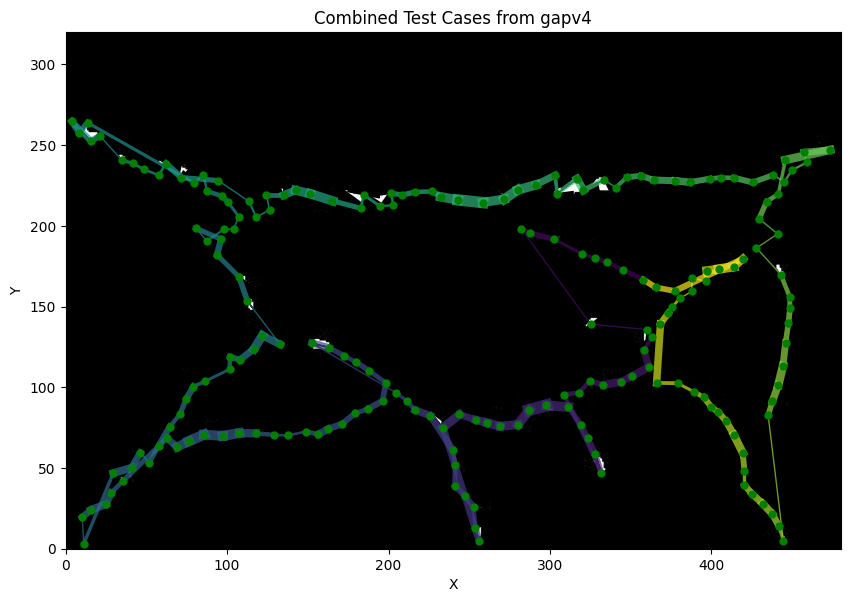

In [10]:
# @title sprayer_path() considers the black percentage under the path as filter to identify the gap jump
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from scipy.spatial import distance_matrix
from sklearn.cluster import KMeans
import networkx as nx
from networkx.algorithms.approximation import traveling_salesman_problem
from sklearn.decomposition import PCA

'''
Change the threshold to determine how sensitive the model is to determine the gap jump,
it's the black/region ratio, default is if over half of points are black, then it's a jump
'''
def sprayer_path(tsp_coordinates, original_contours, key_point_dict, input_path,threshold=0.5):
    plt.figure(figsize=(10, 10))

    num_segments = len(tsp_coordinates) - 1
    thickness_dict = {}  # Dictionary to store thickness information
    gap_threshold = threshold  # Define a threshold for percentage of black pixels

    # Load the original binary image for checking the color under the path
    binary_image = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)

    # Combine all points for smooth plotting
    all_points = []
    for (x1, y1), (x2, y2) in zip(tsp_coordinates[:-1], tsp_coordinates[1:]):
        original_points = key_point_dict.get((x1, y1), [])
        if original_points:
            direction = calculate_direction(original_points)
            thickness = calculate_thickness((x1, y1), direction, original_points)
            thickness_dict[(x1, y1)] = {
                'thickness': thickness,
                'original_points': original_points,
                'direction': direction.tolist()
            }
        else:
            thickness = 0.0  # Default thickness if no points are found
        all_points.extend([(x1, y1), (x2, y2)])

    all_points = np.array(all_points)

    lines = [[all_points[i], all_points[i + 1]] for i in range(len(all_points) - 1)]

    # Calculate line thicknesses based on thickness_dict
    line_thicknesses = []
    line_styles = []  # To store line styles (solid or dashed)
    for i in range(len(lines) - 1):
        key_point1_tuple = tuple(lines[i][0])
        key_point2_tuple = tuple(lines[i + 1][0])
        thickness1 = thickness_dict.get(key_point1_tuple, {}).get('thickness', 1.0)
        thickness2 = thickness_dict.get(key_point2_tuple, {}).get('thickness', 1.0)

        # Generate points along the line
        line_points = np.linspace(lines[i][0], lines[i][1], num=100, dtype=int)
        line_points[:, 0] = np.clip(line_points[:, 0], 0, binary_image.shape[1] - 1)
        line_points[:, 1] = np.clip(line_points[:, 1], 0, binary_image.shape[0] - 1)

        # Check the color of the points along the line
        black_count = 0
        total_count = len(line_points)
        for point in line_points:
            x, y = point
            if binary_image[y, x] == 0:  # Black pixel
                black_count += 1

        # Calculate the percentage of black pixels
        black_percentage = black_count / total_count

        # Determine if the segment is a jump based on the black pixel percentage
        if black_percentage > gap_threshold:
            line_thicknesses.append(1.0)  # Default minimal thickness for gaps
            line_styles.append('dashed')  # Use dashed lines for gaps
        else:
            line_thicknesses.append((thickness1 + thickness2) / 2)
            line_styles.append('solid')  # Use solid lines for continuous segments

    key_point_last = tuple(lines[-1][0])
    line_thicknesses.append(thickness_dict.get(key_point_last, {}).get('thickness', 1.0))
    line_styles.append('solid')

    # Plot the line segments
    for i, (line, thickness, style) in enumerate(zip(lines, line_thicknesses, line_styles)):
        color = plt.cm.viridis(i / len(lines))  # Use colormap to get gradual color change
        plt.plot(*zip(*line), color=color, linewidth=thickness, alpha=0.7)  # Set alpha for transparency

    # Plot arrows to indicate direction
    for i in range(len(tsp_coordinates) - 1):
        plt.arrow(tsp_coordinates[i][0], tsp_coordinates[i][1],
                  tsp_coordinates[i+1][0] - tsp_coordinates[i][0], tsp_coordinates[i+1][1] - tsp_coordinates[i][1],
                  head_width=20, head_length=30, fc='k', ec='k')

    # Plot the key points
    for key_point, _ in key_point_dict.items():
        plt.plot(key_point[0], key_point[1], 'go', markersize=5)

    # Plot the input image as the background
    image = cv2.imread(input_path)
    image_flipped = cv2.flip(image, 0)  # Flip vertically
    plt.imshow(cv2.cvtColor(image_flipped, cv2.COLOR_BGR2RGB), extent=[0, image_flipped.shape[1], 0, image_flipped.shape[0]])

    plt.title("Combined Test Cases from gapv4")
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

# output_path : is not saving into the folder
# STEP1: find path
# XIANG: TODO : adjust this value, either (1) simply remopve close keypoint, or (2) use adjustable num_cluster <*>
num_cluster = 200 # depends on the complexcity

input_path = '/content/drive/MyDrive/Road_surface_crack_detection/finalize/denoised_images/denoised_cracked-pavement1_resized_segmented.jpg'
output_path = '/content/drive/MyDrive/Road_surface_crack_detection/finalize/optimal_paths/denoised_cracked-pavement1_resized_segmented.jpg'
tsp_coordinates, original_contours, key_point_dict = optimize_crack_path(input_path, output_path,num_cluster)

#STEP2: no output
sprayer_path(tsp_coordinates, original_contours, key_point_dict, input_path)


<ipython-input-11-fef55687adc8>:76: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='plasma'), label='Distance along the path')


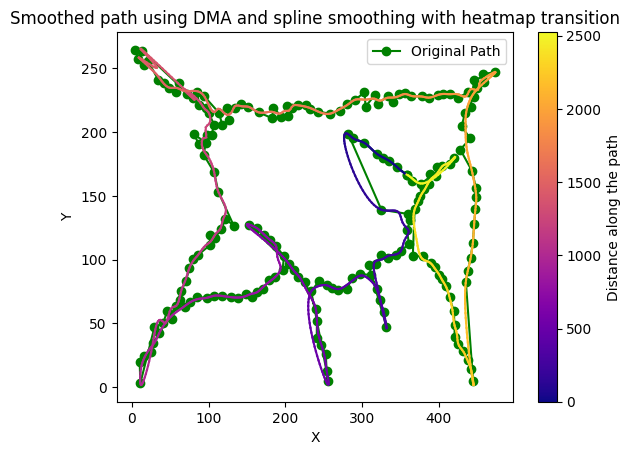

<Figure size 1000x1000 with 0 Axes>

In [11]:
# @title DMA_Spline_smoothing() creates smoothed path for Road Scrapper using Dynamic Moving Average and Spline Smoothing with heatmap color schema
import numpy as np
from scipy.interpolate import splprep, splev
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
'''
Change the min_window and max_window to tune the DMA grouping size
Change the curvature_multiplier to fine-tune the curve effect on the smooth path
  [ especially for loop section, the higher the curvature_multiplier, the smaller the path/less stick to the points ]
'''
def DMA_Spline_smoothing(tsp_coordinates, min_window, max_window, curvature_multiplier, output_path):
  # Get curvature as parameter for the window size, consider both the sharpness and height of the curve
    def calculate_curvature(point1, point2, point3):
        # Calculate side lengths
        a = np.linalg.norm(point2 - point3)
        b = np.linalg.norm(point1 - point3)
        c = np.linalg.norm(point1 - point2)

        if a == 0 or b == 0 or c == 0:
            return 0

        # Calculate the area of the triangle using the determinant method
        area = 0.5 * np.abs(np.linalg.det(np.array([
            [point1[0], point1[1], 1],
            [point2[0], point2[1], 1],
            [point3[0], point3[1], 1]
        ])))

        # Calculate the curvature
        curvature = 4 * area / (a * b * c)
        return curvature

    # Using DMA on tsp_points for grouped points and reduced noise
    def dynamic_moving_average(tsp_points, min_window, max_window, curvature_multiplier):
        smoothed_points = []
        for i in range(1, len(tsp_points) - 1):
            curvature = calculate_curvature(tsp_points[i-1], tsp_points[i], tsp_points[i+1])
            window_size = int(min_window + (max_window - min_window) * curvature * curvature_multiplier)
            window_size = max(min_window, min(window_size, max_window))

            start = max(0, i - window_size // 2)
            end = min(len(tsp_points), i + window_size // 2 + 1)
            window_points = tsp_points[start:end]
            smoothed_points.append(window_points.mean(axis=0))

        smoothed_points = [tsp_points[0]] + smoothed_points + [tsp_points[-1]]
        return np.array(smoothed_points)

    # Using spline to connect the reduced tsp_points from DMA result
    def smooth_path_spline(coordinates):
        x = coordinates[:, 0]
        y = coordinates[:, 1]
        tck, u = splprep([x, y], s=0)
        unew = np.linspace(0, 1, 1000)
        out = splev(unew, tck)
        return np.vstack(out).T

    # Applying dynamic moving average
    smoothed_path_dynamic = dynamic_moving_average(tsp_coordinates, min_window, max_window, curvature_multiplier)

    # Applying spline smoothing
    smoothed_path = smooth_path_spline(smoothed_path_dynamic)

     # Plot the original path
    plt.plot(tsp_coordinates[:, 0], tsp_coordinates[:, 1], 'go-', label='Original Path')

    # Calculate distances along the path
    distances = np.cumsum(np.sqrt(np.sum(np.diff(smoothed_path, axis=0)**2, axis=1)))
    distances = np.insert(distances, 0, 0)  # Insert 0 at the beginning for the starting point
    norm = Normalize(vmin=distances.min(), vmax=distances.max())

    # Plot the heatmap transition
    for i in range(1, len(smoothed_path)):
        plt.plot(smoothed_path[i-1:i+1, 0], smoothed_path[i-1:i+1, 1], color=plt.cm.plasma(norm(distances[i])))

    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='plasma'), label='Distance along the path')
    plt.title('Smoothed path using DMA and spline smoothing with heatmap transition')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.figure(figsize = (10,10))
    if output_path:
      plt.savefig(output_path)
    plt.show()

    return smoothed_path



# Example usage
input_path = '/content/drive/MyDrive/Road_surface_crack_detection/finalize/denoised_images/denoised_cracked-pavement1_resized_segmented.jpg'
output_path = '/content/drive/MyDrive/Road_surface_crack_detection/finalize/smoothed_paths/denoised_cracked-pavement1_resized_segmented.jpg'
tsp_coordinates, original_contours, key_point_dict = optimize_crack_path(input_path, output_path, num_cluster=200)
tsp_coordinates = np.array(tsp_coordinates)
min_window = 1
max_window = 10
curvature_multiplier = 4

smoothed_path = DMA_Spline_smoothing(tsp_coordinates, min_window, max_window, curvature_multiplier, output_path)


In [12]:
smoothed_path

array([[357.83333333, 166.66666667],
       [355.54981985, 167.56419821],
       [353.30590235, 168.55947513],
       ...,
       [362.52798187, 164.9119228 ],
       [360.25719854, 165.88648574],
       [357.83333333, 166.66666667]])

In [13]:
tsp_coordinates

array([[357.83333333, 166.66666667],
       [345.125     , 172.75      ],
       [335.55555556, 177.33333333],
       [327.81818182, 179.90909091],
       [319.6       , 182.8       ],
       [302.6       , 191.6       ],
       [287.5       , 195.5       ],
       [282.25      , 198.125     ],
       [325.09090909, 139.09090909],
       [360.14285714, 135.71428571],
       [362.85714286, 130.85714286],
       [358.27272727, 122.81818182],
       [361.08333333, 112.41666667],
       [350.57142857, 106.71428571],
       [343.83333333, 103.33333333],
       [333.11111111, 101.44444444],
       [324.6       , 103.8       ],
       [318.1       ,  96.7       ],
       [308.77777778,  95.33333333],
       [331.75      ,  47.0625    ],
       [328.09090909,  58.63636364],
       [323.26666667,  68.6       ],
       [319.21428571,  76.64285714],
       [311.41666667,  87.75      ],
       [297.7       ,  88.8       ],
       [287.22222222,  85.88888889],
       [280.1       ,  76.9       ],
 

### Attempts for automated num_cluster decision

Optimal num_cluster: 20


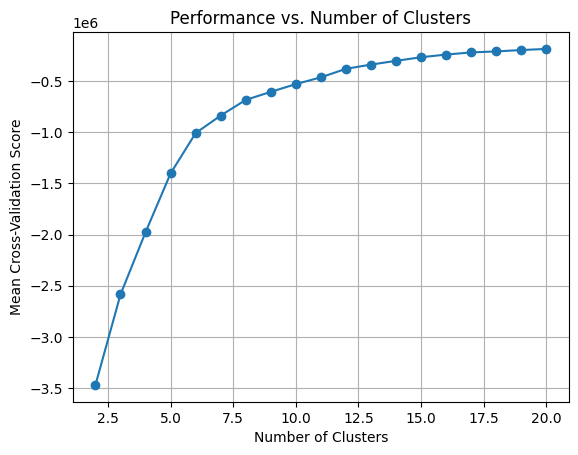

In [14]:
import numpy as np
import cv2
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score, KFold

def optimize_crack_path_auto_cluster(input_path, num_cluster_range=(2, 20), num_folds=5):
    # Read the input image
    image = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)

    # Threshold the image to get a binary image
    _, binary_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

    # Find contours in the binary image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Extract key points from contours
    key_points = []
    for contour in contours:
        for point in contour:
            key_points.append(point[0])
    key_points = np.array(key_points).reshape(-1, 2)

    # Initialize variables to store cross-validation results
    cv_scores = []
    num_clusters_tried = []

    # Perform cross-validation for each num_cluster in the specified range
    for num_cluster in range(num_cluster_range[0], num_cluster_range[1] + 1):
        kmeans = KMeans(n_clusters=num_cluster, random_state=0, n_init=5)
        kf = KFold(n_splits=num_folds, shuffle=True, random_state=0)
        scores = cross_val_score(kmeans, key_points, cv=kf)
        cv_scores.append(scores.mean())
        num_clusters_tried.append(num_cluster)

    # Determine the optimal num_cluster based on cross-validation results
    optimal_num_cluster = np.argmax(cv_scores) + num_cluster_range[0]

    # Print the final num_cluster used
    print("Optimal num_cluster:", optimal_num_cluster)

    # Plot performance for each num_cluster
    plt.plot(num_clusters_tried, cv_scores, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Mean Cross-Validation Score')
    plt.title('Performance vs. Number of Clusters')
    plt.grid(True)
    plt.show()

    return optimal_num_cluster, num_clusters_tried, cv_scores

# Example usage
input_path = '/content/drive/MyDrive/Road_surface_crack_detection/finalize/denoised_images/denoised_cracked-pavement1_resized_segmented.jpg'
optimal_num_cluster, num_clusters_tried, cv_scores = optimize_crack_path_auto_cluster(input_path)


Optimal num_cluster: 20


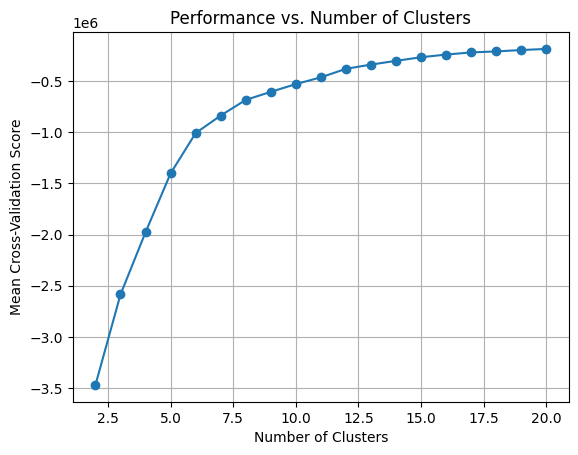

Using num_cluster: 20


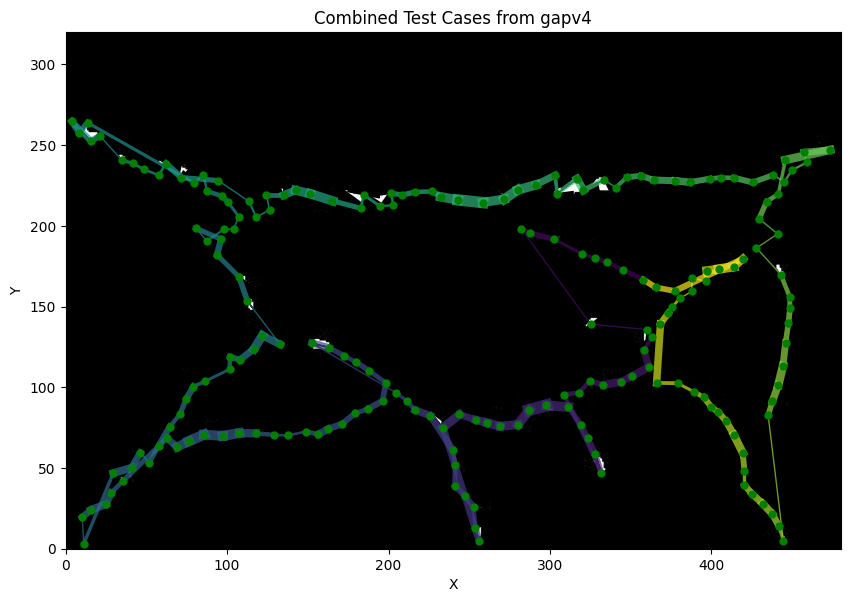

In [15]:
def sprayer_path_v2(tsp_coordinates, original_contours, key_point_dict, input_path, threshold=0.5):
    optimal_num_cluster, num_clusters_tried, cv_scores = optimize_crack_path_auto_cluster(input_path)
    print("Using num_cluster:", optimal_num_cluster)

    plt.figure(figsize=(10, 10))

    num_segments = len(tsp_coordinates) - 1
    thickness_dict = {}  # Dictionary to store thickness information
    gap_threshold = threshold  # Define a threshold for percentage of black pixels

    # Load the original binary image for checking the color under the path
    binary_image = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)

    # Combine all points for smooth plotting
    all_points = []
    for (x1, y1), (x2, y2) in zip(tsp_coordinates[:-1], tsp_coordinates[1:]):
        original_points = key_point_dict.get((x1, y1), [])
        if original_points:
            direction = calculate_direction(original_points)
            thickness = calculate_thickness((x1, y1), direction, original_points)
            thickness_dict[(x1, y1)] = {
                'thickness': thickness,
                'original_points': original_points,
                'direction': direction.tolist()
            }
        else:
            thickness = 1.0  # Default thickness if no points are found
        all_points.extend([(x1, y1), (x2, y2)])

    all_points = np.array(all_points)

    lines = [[all_points[i], all_points[i + 1]] for i in range(len(all_points) - 1)]

    # Calculate line thicknesses based on thickness_dict
    line_thicknesses = []
    line_styles = []  # To store line styles (solid or dashed)
    for i in range(len(lines) - 1):
        key_point1_tuple = tuple(lines[i][0])
        key_point2_tuple = tuple(lines[i + 1][0])
        thickness1 = thickness_dict.get(key_point1_tuple, {}).get('thickness', 1.0)
        thickness2 = thickness_dict.get(key_point2_tuple, {}).get('thickness', 1.0)

        # Generate points along the line
        line_points = np.linspace(lines[i][0], lines[i][1], num=100, dtype=int)
        line_points[:, 0] = np.clip(line_points[:, 0], 0, binary_image.shape[1] - 1)
        line_points[:, 1] = np.clip(line_points[:, 1], 0, binary_image.shape[0] - 1)

        # Check the color of the points along the line
        black_count = 0
        total_count = len(line_points)
        for point in line_points:
            x, y = point
            if binary_image[y, x] == 0:  # Black pixel
                black_count += 1

        # Calculate the percentage of black pixels
        black_percentage = black_count / total_count

        # Determine if the segment is a jump based on the black pixel percentage
        if black_percentage > gap_threshold:
            line_thicknesses.append(1.0)  # Default minimal thickness for gaps
            line_styles.append('dashed')  # Use dashed lines for gaps
        else:
            line_thicknesses.append((thickness1 + thickness2) / 2)
            line_styles.append('solid')  # Use solid lines for continuous segments

    key_point_last = tuple(lines[-1][0])
    line_thicknesses.append(thickness_dict.get(key_point_last, {}).get('thickness', 1.0))
    line_styles.append('solid')

    # Plot the line segments
    for i, (line, thickness, style) in enumerate(zip(lines, line_thicknesses, line_styles)):
        color = plt.cm.viridis(i / len(lines))  # Use colormap to get gradual color change
        plt.plot(*zip(*line), color=color, linewidth=thickness, alpha=0.7)  # Set alpha for transparency

    # Plot arrows to indicate direction
    for i in range(len(tsp_coordinates) - 1):
        plt.arrow(tsp_coordinates[i][0], tsp_coordinates[i][1],
                  tsp_coordinates[i+1][0] - tsp_coordinates[i][0], tsp_coordinates[i+1][1] - tsp_coordinates[i][1],
                  head_width=20, head_length=30, fc='k', ec='k')

    # Plot the key points
    for key_point, _ in key_point_dict.items():
        plt.plot(key_point[0], key_point[1], 'go', markersize=5)

    # Plot the input image as the background
    image = cv2.imread(input_path)
    image_flipped = cv2.flip(image, 0)  # Flip vertically
    plt.imshow(cv2.cvtColor(image_flipped, cv2.COLOR_BGR2RGB), extent=[0, image_flipped.shape[1], 0, image_flipped.shape[0]])

    plt.title("Combined Test Cases from gapv4")
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

# Example usage
input_path = '/content/drive/MyDrive/Road_surface_crack_detection/finalize/denoised_images/denoised_cracked-pavement1_resized_segmented.jpg'
sprayer_path_v2(tsp_coordinates, original_contours, key_point_dict, input_path)